# Imports

In [244]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

# Set Tensorflow 

In [427]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Set random seed for reproducibility

In [ ]:
numpy.random.seed(1234)
tensorflow.set_random_seed(1234)

# Loading Data

In [245]:
with open("options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [246]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

# Preparing and Transforming Data

In [247]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [248]:
groups = RUG['Location 2 - consumption'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

In [249]:
temp = temp[::10]

In [250]:
train_percentage = 0.8
train_size = int(len(temp.columns) * train_percentage)
train_size

1702

In [251]:
train = temp.iloc[:, :train_size]
test = temp.iloc[:, train_size:]

In [252]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [256]:
scaled_list_train = [train[col] for col in train]

# for i in range(len(scaled_list_tain)):
#     scaler = MinMaxScaler()
#     scaled_list_tain[i] = MinMaxScaler().fit_transform(scaled_list_tain[i].to_numpy().reshape(-1, 1))
#     scaled_list_tain[i]= scaled_list_tain[i].reshape(len(scaled_list_tain[i]))

# scaled_list_train = np.nan_to_num(scaled_list_tain, copy=False, nan=0.0)
scaled_list_train = scaler.fit_transform(scaled_list_train)
scaled_list_train

array([[0.17881265, 0.17840637, 0.18230088, ..., 0.09634284, 0.09634284,
        0.12386668],
       [0.04017064, 0.03969576, 0.04424779, ..., 0.13174732, 0.13174732,
        0.1581928 ],
       [0.15926058, 0.22678519, 0.23379805, ..., 0.09465692, 0.09465692,
        0.12223211],
       ...,
       [0.02986136, 0.02724738, 0.05734513, ..., 0.17659299, 0.16445432,
        0.19578807],
       [0.12584429, 0.13608185, 0.09132743, ..., 0.07341423, 0.069368  ,
        0.16048121],
       [0.07038748, 0.0784636 , 0.08495575, ..., 0.07341423, 0.05115998,
        0.08790598]])

In [257]:
scaled_list_test = [test[col] for col in test]

# for i in range(len(scaled_list_test)):
#     scaler = MinMaxScaler()
#     scaled_list_test[i] = MinMaxScaler().fit_transform(scaled_list_test[i].to_numpy().reshape(-1, 1))
#     scaled_list_test[i]= scaled_list_test[i].reshape(len(scaled_list_test[i]))

# scaled_list_test = np.nan_to_num(scaled_list_test, copy=False, nan=0.0)
scaled_list_test = scaler.transform(scaled_list_test)

scaled_list_test

array([[0.0234625 , 0.02084535, 0.0339823 , ..., 0.16850054, 0.24537884,
        0.19382658],
       [0.14077497, 0.11474176, 0.14654867, ..., 0.21300902, 0.20289347,
        0.15851971],
       [0.13224316, 0.04218544, 0.04035398, ..., 0.18670856, 0.17456989,
        0.21148001],
       ...,
       [0.01919659, 0.00804129, 0.05309735, ..., 0.08959913, 0.13208451,
        0.08790598],
       [0.08745111, 0.0101753 , 0.01486726, ..., 0.1604081 , 0.08352979,
        0.11928987],
       [0.06612158, 0.11687577, 0.21663716, ..., 0.12399206, 0.04913687,
        0.08594449]])

# Principal Component Analysis

Shape before PCA:  (1702, 144)
Shape after PCA:  (1702, 10)


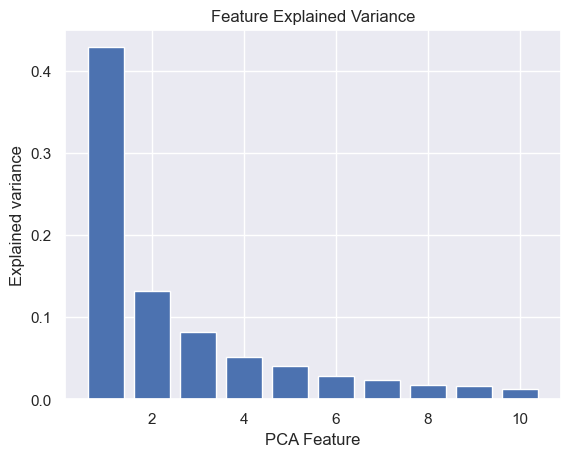

In [258]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
# pca = PCA(n_components=cluster_count)
pca = PCA(n_components=0.85, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list_train)
 

print('Shape before PCA: ', scaled_list_train.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance  
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

# Added K-means

In [13]:
wcss = []
silhouette_scores = []
for i in range(1,10):
    print(i)
    kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(pca_features)
    wcss.append(kmeans_pca.inertia_)
    # print("silhouette_score")
    # try:
    #     silhouette_scores.append(silhouette_score(pca_features, kmeans_pca.labels_, n_jobs=-1))
    # except:
    #     silhouette_scores.append(0)

1
2
3
4
5
6
7
8
9


Text(0.5, 0, 'Number of clusters')

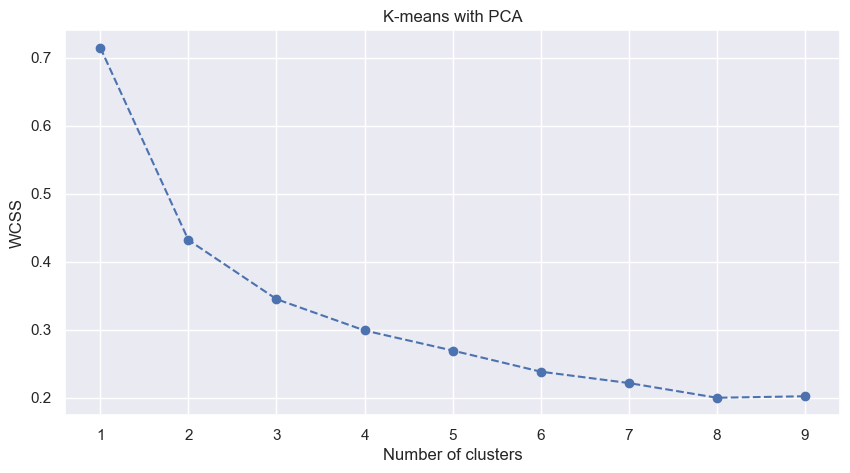

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('WCSS')
plt.xlabel('Number of clusters')

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

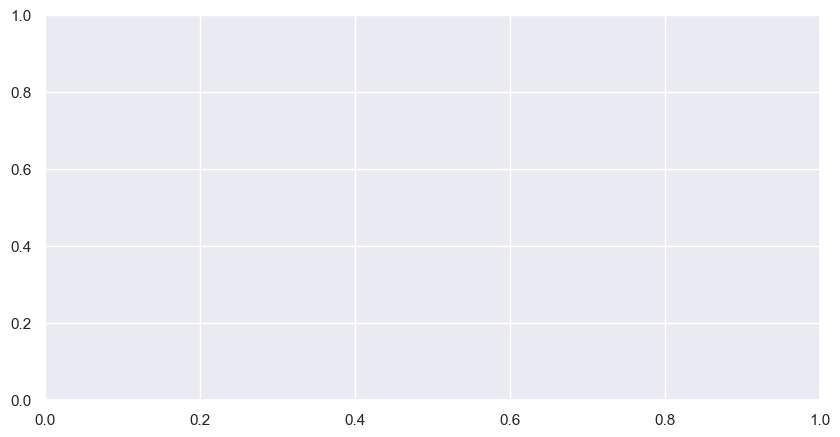

In [16]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), silhouette_scores, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')

from these graphs, we see that the elbow is at around 3, so we will use 3 clusters for the k-means algorithm.

In [261]:
from collections import Counter
kmeans_pca = TimeSeriesKMeans(n_clusters=4, metric="dtw", n_jobs=-1).fit(pca_features)
train_pca_features = kmeans_pca.predict(scaled_list_train)
test_pca_features = kmeans_pca.predict(scaled_list_test)

Counter(train_pca_features), Counter(test_pca_features)

c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1702 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
c:\Users\mjnst\anaconda3\envs\thesis\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 426 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(Counter({0: 696, 1: 1004, 2: 2}), Counter({1: 156, 0: 269, 2: 1}))

In [266]:
scaled_list_train.shape

(1702, 144)

In [ ]:
# counts = Counter(train_pca_features)
# plt.bar(counts.keys(), counts.values())

# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i,y[i],y[i])

# addlabels(counts.keys(), list(counts.values()))

# plt.show()


# Train different lstm models

In [14]:
look_back=3

In [274]:
scaled_list_train[0]

array([[0.17881265, 0.17840637, 0.18230088, ..., 0.09634284, 0.09634284,
        0.12386668],
       [0.04017064, 0.03969576, 0.04424779, ..., 0.13174732, 0.13174732,
        0.1581928 ],
       [0.15926058, 0.22678519, 0.23379805, ..., 0.09465692, 0.09465692,
        0.12223211],
       ...,
       [0.02986136, 0.02724738, 0.05734513, ..., 0.17659299, 0.16445432,
        0.19578807],
       [0.12584429, 0.13608185, 0.09132743, ..., 0.07341423, 0.069368  ,
        0.16048121],
       [0.07038748, 0.0784636 , 0.08495575, ..., 0.07341423, 0.05115998,
        0.08790598]])

In [277]:
# cat_0 = scaled_list_train[np.where(train_pca_features == 0)].flatten().reshape(-1, 1)
cat_0 = scaled_list_train[np.where(train_pca_features == 0)]
cat_0.shape

(696, 144)

In [322]:
from tqdm import tqdm

In [450]:
def func(train1, test1, name='LSTM'):

    training, testing = train1.copy(), test1.copy()

    look_back = 3
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)


    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

    for train_it in tqdm(training): 
        train_it = train_it.reshape(-1, 1)
           
        # reshape into X=t and Y=t+1
        trainX, trainY = create_dataset(train_it, look_back)
        # testX, testY = create_dataset(testing, look_back)

    # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        # testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        model.fit(trainX, trainY, epochs=50, verbose=0, callbacks=[callback], batch_size=32)

    
    rmse_train = []
    rmse_test = []

    mae_train = []
    mae_test = []

    mape_train = []
    mape_test = []

    for train_it, test_it in zip(training, testing):   
        train_it = train_it.reshape(-1, 1)
        test_it = test_it.reshape(-1, 1) 
        # reshape into X=t and Y=t+1
        look_back = 3
        trainX, trainY = create_dataset(train_it, look_back)
        testX, testY = create_dataset(testing, look_back)
    # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # make predictions
        trainPredict = model.predict(trainX, verbose=0)
        testPredict = model.predict(testX, verbose=0)
        # invert predictions
        trainPredict = np.repeat(trainPredict, scaled_list_train.shape[1], axis=-1)
        trainPredict = scaler.inverse_transform(trainPredict)[:,0]

        trainY = np.repeat(trainY.reshape(-1, 1), scaled_list_train.shape[1], axis=-1)
        trainY = scaler.inverse_transform(trainY)[:,0]
        
        testPredict = np.repeat(testPredict, scaled_list_test.shape[1], axis=-1)
        testPredict = scaler.inverse_transform(testPredict)[:,0]

        testY = np.repeat(testY.reshape(-1, 1), scaled_list_test.shape[1], axis=-1)
        testY = scaler.inverse_transform(testY)[:,0]

        # calculate different evaluation metrics
        rmse_train.append(np.sqrt(mean_squared_error(trainY, trainPredict)))
        rmse_test.append(np.sqrt(mean_squared_error(testY, testPredict)))

        mae_train.append(tf.keras.metrics.mean_absolute_error(trainY, trainPredict).numpy())
        mae_test.append(tf.keras.metrics.mean_absolute_error(testY, testPredict).numpy())


        mape_train.append(tf.keras.metrics.mean_absolute_percentage_error(trainY, trainPredict).numpy())
        mape_test.append(tf.keras.metrics.mean_absolute_percentage_error(testY, testPredict).numpy())

    return (name, (rmse_train, rmse_test, mae_train, mae_test, mape_train, mape_test))
    # return (name, (rmse_train, rmse_test, mae_train, mae_test, mape_train, mape_test))

In [508]:
complete_results = []

location = "Location 1 - flow"
for cluster in [*Counter(train_pca_features)][:2]:
    cluster_train = scaled_list_train[np.where(train_pca_features == cluster)][:5]
    cluster_test = scaled_list_test[np.where(test_pca_features == cluster)][:5]

    reply = func(cluster_train, cluster_test)
    # reply_dict = {f'Cluster {cluster}': {'rmse_train': np.mean(reply[1][0]), 'rmse_test': np.mean(reply[1][1]), 'mae_train': np.mean(reply[1][2]), 'mae_test': np.mean(reply[1][3]), 'mape_train': np.mean(reply[1][4]), 'mape_test': np.mean(reply[1][5])}}
    
    complete_results.append([np.mean(reply[1][0]), np.mean(reply[1][1]), np.mean(reply[1][2]), np.mean(reply[1][3]), np.mean(reply[1][4]), np.mean(reply[1][5])])

100%|██████████| 5/5 [00:15<00:00,  3.14s/it]


In [509]:

import pandas as pd
multi_index = pd.MultiIndex.from_tuples([(Location, Cluster) for Location in RUG.columns for Cluster in [*Counter(train_pca_features)][:2]],
                                       names=['Location','Cluster'])


cols = pd.MultiIndex.from_tuples([('Train', 'rmse'), ('Train', 'mae'), ('Train', 'mape'), ('Test', 'rmse'), ('Test', 'mae'), ('Test', 'mape')])

df = pd.DataFrame(complete_results, columns=cols,index=multi_index)
df


ValueError: Length of values (2) does not match length of index (26)